In [1]:
import numpy as np
from PIL import Image
import cv2
import openslide
import json
import torch
import random
from matplotlib import pyplot as plt
import pandas as pd

/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting List of Coordinates for the Image to be Visualized.

In [2]:
def read_file(path):

    """
        Inputs: Feature File Path
        Ouputs: A Dataframe with File Name and corresponding Extracted Feature List
    """
    file_dict = pd.read_pickle(path)
    df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
    return df
    

In [9]:
# Specify the Path to the Extracted Feature File (If Feature vectors for multiple slides are in a single pickle file)
df = read_file('/mnt/largedrive0/katariap/feature_extraction/data/Dataset/FineTuned_Model_Features_dict.pickle')

In [13]:
patch_list = df['Name'].to_list()
selected_image_patch_list = []
selected_image = '632'  # Specify the Sample ID of the Whole Slide Image

for name in patch_list:

    image_name = name.split('/')[-2]
    image_name = ((image_name).split(' ')[1]).split('.')[0]

    if(image_name == selected_image):
        selected_image_patch_list = selected_image_patch_list + [name]

In [10]:
def process_file_paths_to_coordinates(item):
    """
        Inputs: Path of the Image Patch
        Ouputs: Returns the Coordinates of the image Patch
    """

    item = item.split('/')[-1]
    item = item.split(' ')[-1]
    item = item.split('.')[0]
    item = item.split('[')[1]
    item = item.split(']')[0]
    coords = item.split(',')
    x = coords[0].split('=')[-1]
    y = coords[1].split('=')[-1]
    item = [int(x),int(y)]
    return item

In [16]:
coords = [] #Process the file paths to get image coordinates
for patch in selected_image_patch_list:
    coords = coords + [process_file_paths_to_coordinates(patch)]

#### Run the below cell for co-ordinate extraction if each wsi has separate feature vector file (json)

In [ ]:
# If The DenseNet features have been Used to Run the model. 
# Use the Feature vector file corresponding to the whole slide for extracting image coordinates.

file_path = '' # Path to the feature vector file
with open(file_path,'r') as file:
    feature_dict = json.loads(file.read())
file_paths = list(feature_dict.keys())

coords = []
for patch in file_paths:
    coords = coords + [process_file_paths_to_coordinates(patch)]

In [ ]:
attention_file_path = '/content/drive/MyDrive/MITACS/19kimianet.npy'
attentions = np.load(attention_file_path) # Specify the Path to attentions weights file

Downsample the Whole Slide .vsi Image to by 10X Using QuPath And Upload it to the server for visualization.

In [19]:
# open the whole slide image using openslide
wsi = openslide.open_slide('/mnt/largedrive0/katariap/feature_extraction/data/Dataset/WSI_downscaled/Sample 632.vsi - 20x.tif')

In [ ]:
#Calculations to Extract Relevent weights from attention matrix extracted for each whole slide image

n = len(coords)
add_length = int((attention_file_path.split('/')[-1]).split('_')[0]) ## The Add length is the integer at start of the file name
n2 = n + add_length + 1
m = 256

if n2 % m > 0:
     padding = m - (n2 %m)
else:
    padding = 0
print(padding)

238


In [ ]:
# Add attentions from all 8 heads 
for i in range(8):
    attention_matrix = attentions[0, i, padding:(padding + n), padding:(padding + n)]

In [ ]:
final_list = [] #List to store only the self attention weights for each patch in the whole slide
for i in range(len(coords)):
    final_list = [attention_matrix[i][i]] + final_list
scores = final_list

In [ ]:
def to_percentiles(scores):
    """
        Function to convert scores to percentiles
    """
    from scipy.stats import rankdata
    scores = rankdata(scores, 'average')/len(scores) * 100   
    return scores


In [ ]:
def block_blending(img,top_left,bot_right, alpha=0.5,block_size=1024):

        """
            Helper Function to blend the base canvas and the heatmaps over it.
            Inputs: 
                img: The img array with heatmap overlayed
                top_left: top_left coordinate
                bot_right: bottom right coordinate
                alpha: how much to blend the block
            Returns:
                Blended image based on block size and alpha
        """
       
        # downsample = self.level_downsamples[vis_level]
        w = img.shape[1]
        h = img.shape[0]
        block_size_x = min(block_size, w)
        block_size_y = min(block_size, h)
        print('using block size: {} x {}'.format(block_size_x, block_size_y))

        shift = top_left
        for x_start in range(top_left[0], bot_right[0], block_size_x * int(10)):
            for y_start in range(top_left[1], bot_right[1], block_size_y * int(10)):
                #print(x_start, y_start)

                # 1. convert wsi coordinates to image coordinates via shift and scale
                x_start_img = int((x_start - shift[0]) / int(10))
                y_start_img = int((y_start - shift[1]) / int(10))
                
                # 2. compute end points of blend tile, careful not to go over the edge of the image
                y_end_img = min(h, y_start_img+block_size_y)
                x_end_img = min(w, x_start_img+block_size_x)

                if y_end_img == y_start_img or x_end_img == x_start_img:
                    continue
             
                
                # 3. fetch blend block and size
                blend_block = img[y_start_img:y_end_img, x_start_img:x_end_img] 
                blend_block_size = (x_end_img-x_start_img, y_end_img-y_start_img)
                
              
                pt = (x_start, y_start)
                canvas = np.array(wsi.read_region(pt, 0, blend_block_size).convert("RGB"))     
            
                # 5. blend color block and canvas block
                img[y_start_img:y_end_img, x_start_img:x_end_img] = cv2.addWeighted(blend_block, alpha, canvas, 1 - alpha, 0, canvas)
        return img

In [ ]:
downsample = 10 # Change if the downscale factor for original image is changed

In [ ]:
def vis_heatmap(scores,coords,alpha=0.5,cmap = 'coolwarm',blocksize = 1000,binarize = False,thresh = 0.5):

    """
        Function to Generate the heatmaps using attention weights and coordinates
        Inputs:
            scores: The Scores for the image Patches corresponding to the coordinates
            Coordinates: The coords for which heatmaps are to be generated
            Binarize: To remove the patches from the visualization with attention values less than a specific threshold
            thresh: specify the thresh when binarize is True.

        Ouputs:
            The image with heatmap is returned (PIL Image)

    """

    if binarize:
        threshold = thresh
    else:
        threshold = 0.0

    region_size = wsi.level_dimensions[0]
    top_left = (0,0)
    bot_right = wsi.level_dimensions[0]
    w, h = region_size
    scale = [1/downsample,1/downsample]  
    patch_size = np.ceil(np.array([1000,1000])* np.array(scale)).astype(int)
    coords = np.ceil(coords * np.array(scale)).astype(int)

    scores = to_percentiles(scores)

    scores /= 100

    overlay = np.full(np.flip(region_size), 0).astype(float)
    counter = np.full(np.flip(region_size), 0).astype(np.uint16)      
    count = 0

    for idx in range(len(coords)):
        score = scores[idx]
        coord = coords[idx]

        if score >= threshold:
            if binarize:
                score = 1.0
                count+=1
        else:
            score = 0.0

        # accumulate attention
        overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += score
        # accumulate counter
        counter[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += 1

    zero_mask = counter == 0

    if binarize:
        overlay[~zero_mask] = np.around(overlay[~zero_mask] / counter[~zero_mask])
    else:
        overlay[~zero_mask] = overlay[~zero_mask] / counter[~zero_mask]

    del counter

    img = np.array(wsi.read_region(top_left,0, region_size).convert("RGB"))
    twenty_percent_chunk = max(1, int(len(coords) * 0.2))

    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    
    for idx in range(len(coords)):
        if (idx + 1) % twenty_percent_chunk == 0:
            print('progress: {}/{}'.format(idx, len(coords)))

        score = scores[idx]
        coord = coords[idx]

        if score >= threshold:

            raw_block = overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]]

            # image block (either blank canvas or orig image)
            img_block = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]].copy()

            # color block (cmap applied to attention block)
            color_block = (cmap(raw_block) * 255)[:,:,:3].astype(np.uint8)

            img_block = color_block

            img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] = img_block.copy()

    del overlay

    if alpha < 1.0:
        img = block_blending(img,top_left,bot_right,alpha = alpha,block_size = blocksize)

    img = Image.fromarray(img)
    w,h = img.size

    return img

progress: 198/999
progress: 397/999
progress: 596/999
progress: 795/999
progress: 994/999

computing blend
using block size: 100 x 100


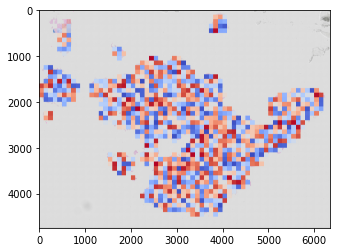

In [ ]:
plt.imshow(vis_heatmap(scores,coords,alpha= 0.3,blocksize=100))

In [ ]:
img = vis_heatmap(scores,coords,alpha= 0.3,blocksize=10000) # Specify block size to be approximately equal to the bottom right corner coordinates

progress: 198/999
progress: 397/999
progress: 596/999
progress: 795/999
progress: 994/999

computing blend
using block size: 6343 x 4748


In [ ]:
# To save the image as tiff file on the server
rgb_img = img.convert('RGB')
rgb_img.save('denseNet.tiff') # specify the file path

progress: 198/999
progress: 397/999
progress: 596/999
progress: 795/999
progress: 994/999

computing blend
using block size: 6343 x 4748


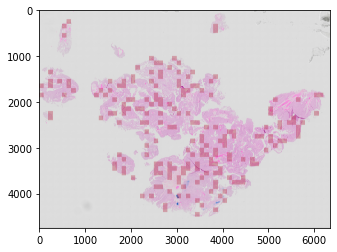

In [ ]:
plt.imshow(vis_heatmap(scores,coords,alpha= 0.3,blocksize=10000,binarize = True,thresh = 0.8))

In [ ]:
img = vis_heatmap(scores,coords,alpha= 0.3,blocksize=10000,binarize = True,thresh = 0.8)

progress: 198/999
progress: 397/999
progress: 596/999
progress: 795/999
progress: 994/999

computing blend
using block size: 6343 x 4748


In [ ]:
# Run this cell with appropriate file name and paths to save the heatmap
rgb_img = img.convert('RGB')
rgb_img.save('kimianet_500_thresh.tiff')

In [ ]:
img = vis_heatmap(scores,coords,alpha= 0.5,blocksize=10000,binarize = True,thresh = 0.92)

progress: 99/500
progress: 199/500
progress: 299/500
progress: 399/500
progress: 499/500

computing blend
using block size: 6343 x 4748


progress: 99/500
progress: 199/500
progress: 299/500
progress: 399/500
progress: 499/500

computing blend
using block size: 6343 x 4748


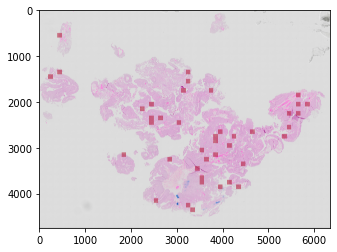

In [ ]:
plt.imshow(vis_heatmap(scores,coords,alpha= 0.5,blocksize=10000,binarize = True,thresh = 0.92))